In [1]:
from helpers import *
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.stats import ks_2samp, wasserstein_distance, ttest_ind, kruskal
import pandas as pd 
from statsmodels.stats.multitest import multipletests

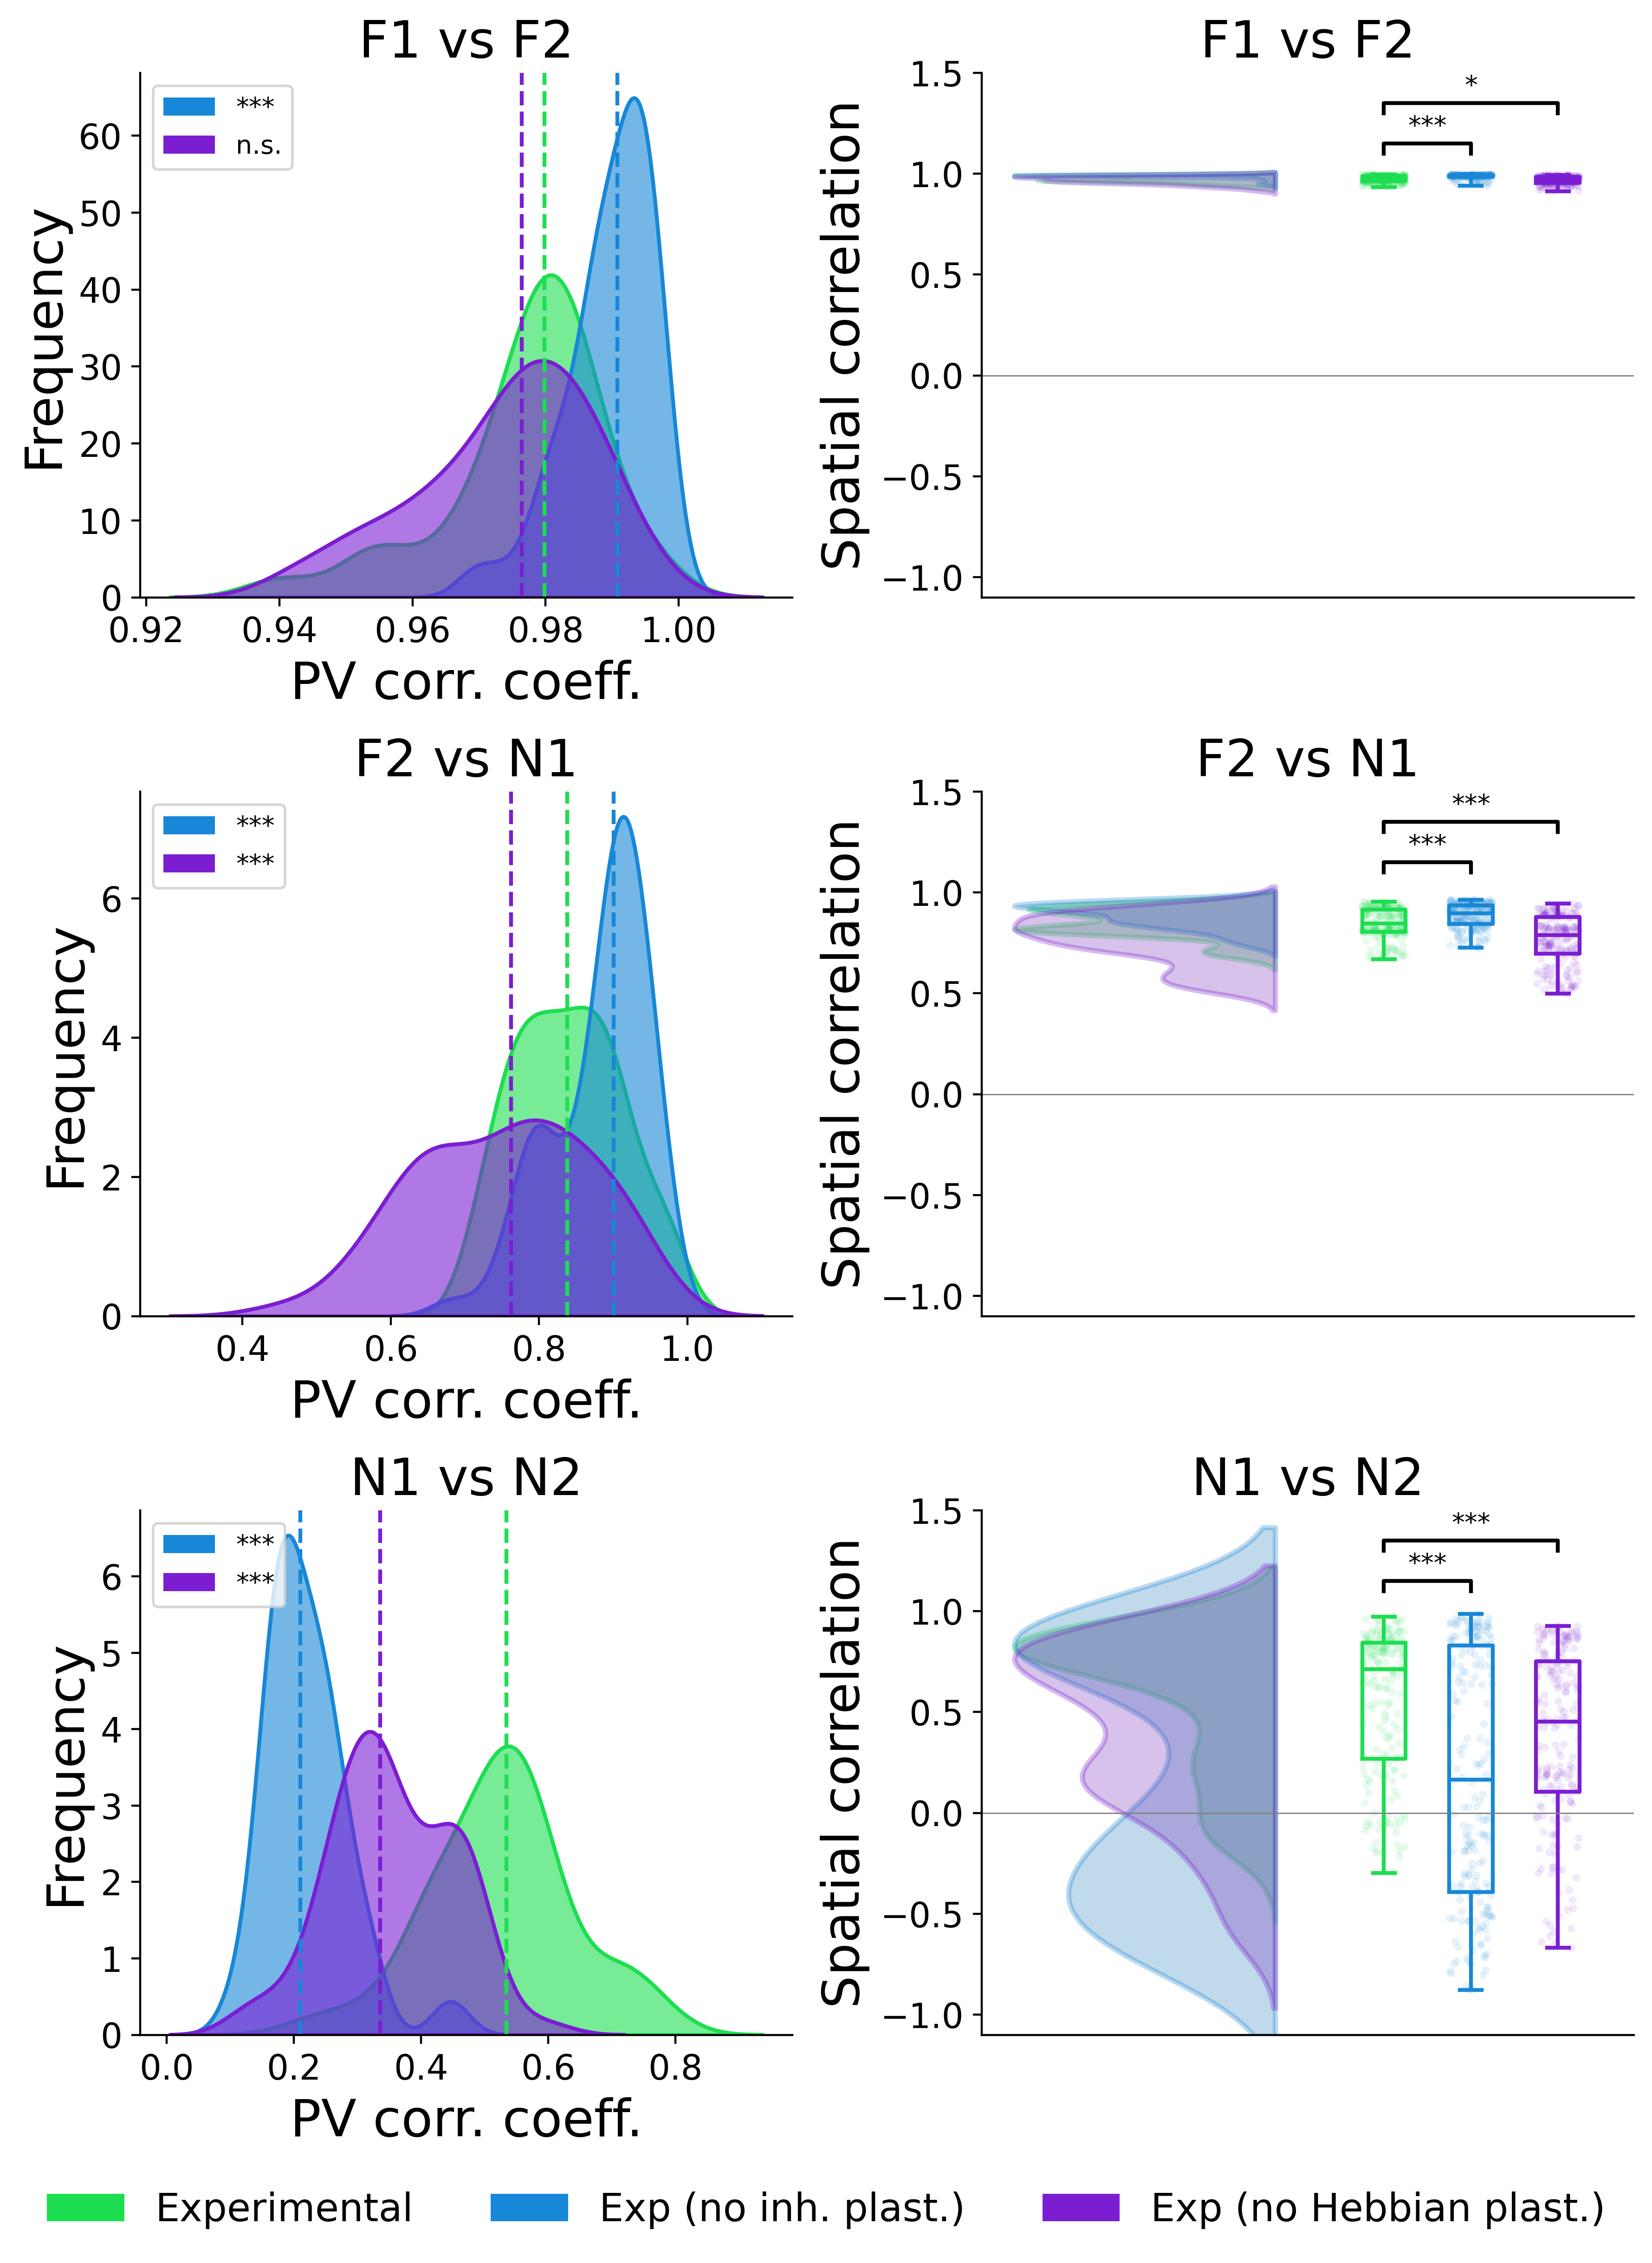

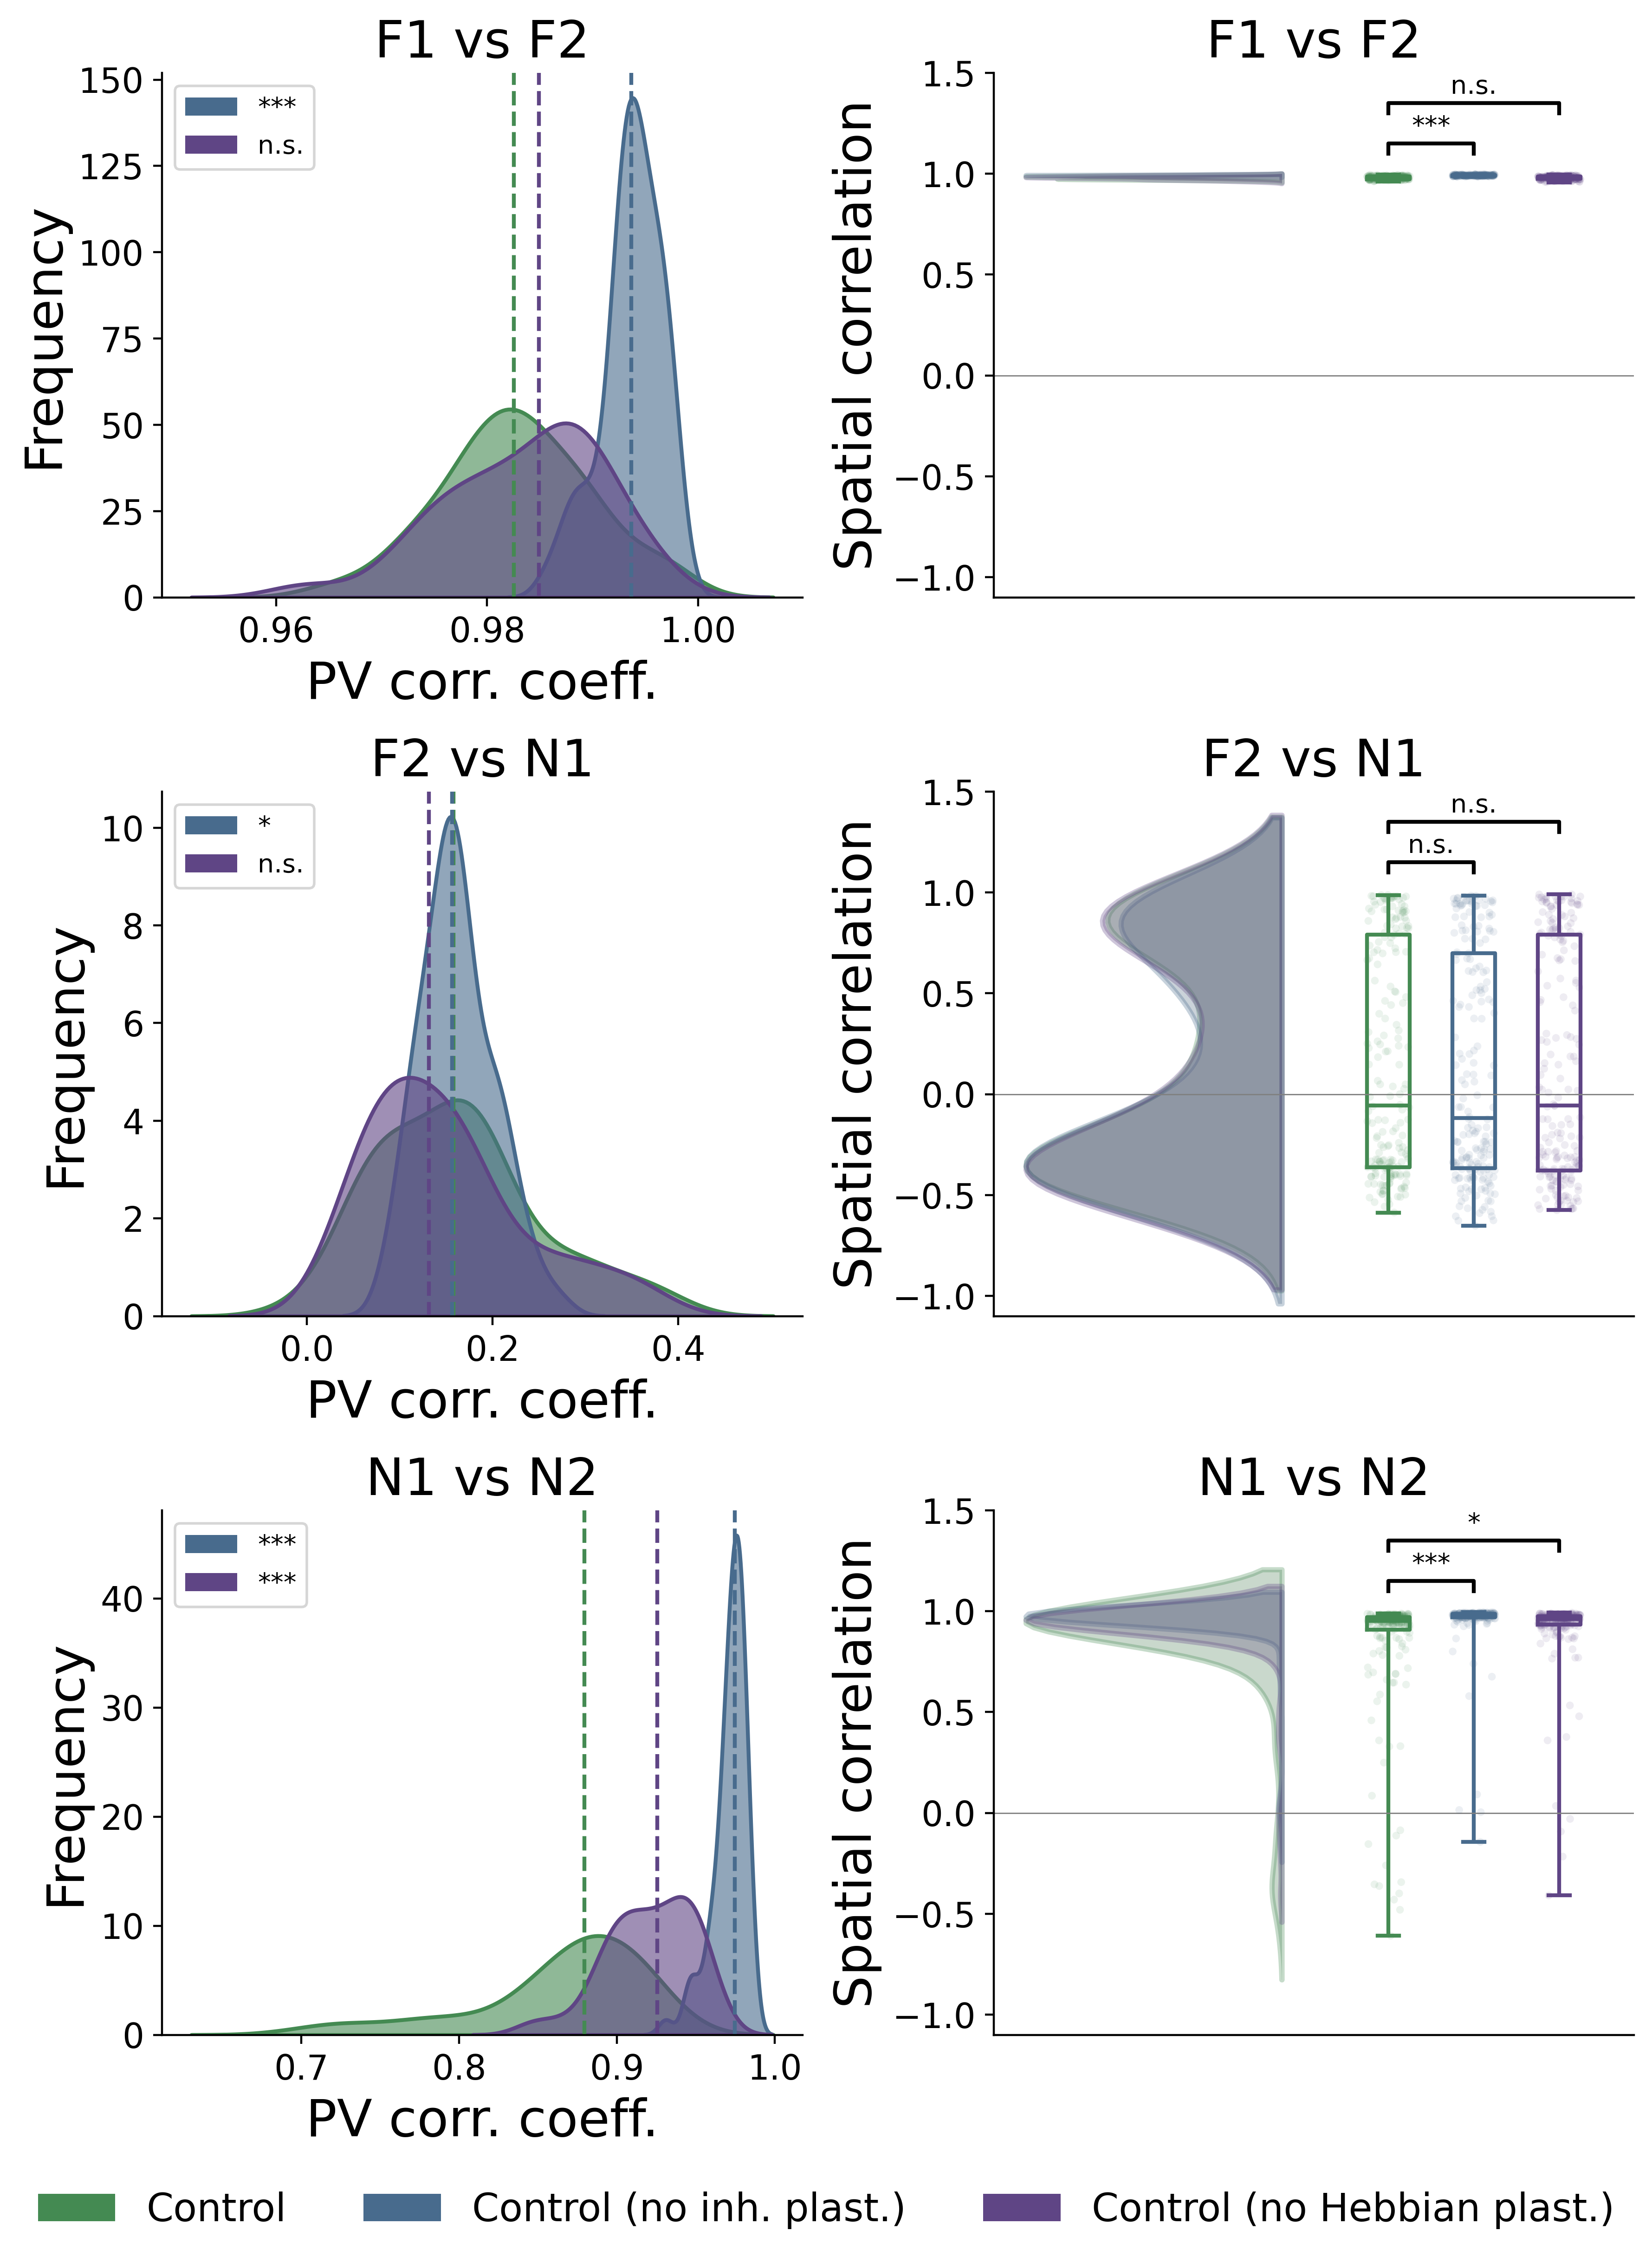

In [2]:
### plot spatial and PV correlations for different plasticity conditions and compute stats

group_names = {
    'exp_normal': 'Experimental',
    'exp_no_inh': 'Exp (no inh. plast.)',
    'exp_no_heb': 'Exp (no Hebbian plast.)',
    'control_normal': 'Control',
    'control_no_inh': 'Control (no inh. plast.)',
    'control_no_heb': 'Control (no Hebbian plast.)',
}

out = {}
amp_per_sc = {}

for scenario in ['normal', 'no_inh', 'no_heb']:
    with open(f"simulations/data/1d_2envs/act_maps_and_pvs_inh_{scenario}.pkl", 'rb') as f:
        amp = pickle.load(f)

    amp_per_sc[scenario] = amp

p_vals = []

for condition in ['exp', 'control']:
    out[condition] = {}
    fig, axs = plt.subplots(3, 2, figsize=(9, 12), dpi=400) 

    for j, measure in enumerate(['pvs_per_condition', 'sp_per_condition']):

        for i, comp in enumerate([('F1', 'F2'), ('F2', 'N1'), ('N1', 'N2')]):
            data1, data2, data3 = (amp_per_sc[k][measure][condition][i] for k in amp_per_sc.keys())
            colors = [COLOR_SETTINGS[f'{condition}_{k}'] for k in amp_per_sc.keys()]

            stat1, p1 = ks_2samp(data1, data2)
            stat2, p2 = ks_2samp(data1, data3)
            was_d1 = wasserstein_distance(data1, data2)
            was_d2 = wasserstein_distance(data1, data3)

            p_vals.append(p1)
            p_vals.append(p2)

            out_vals = [np.mean(data1), np.std(data1), np.mean(data2), np.std(data2), stat1, p1, was_d1, np.mean(data3), np.std(data3), stat2, p2, was_d2]

            out[condition][f'{measure}_{comp[0]}_{comp[1]}'] = [format_val(val) for val in out_vals]

            if j == 0:
                plot_pv_corr_distributions((data1, data2, data3), out1=comp[0], out2=comp[1],
                                            ax=axs[i,j], p=(p1,p2), colors=colors) 
            else:
                create_raincloud_plot((data1, data2, data3), comp[0], comp[1], axs[i, j],
                                        p=(p1,p2), colors=colors) 
            

    columns = ['m1', 'sd1', 'm2', 'sd2', 'D1', 'p1', 'd()1', 'm3', 'sd3', 'D2', 'p2', 'd()2']
    out[condition] = pd.DataFrame.from_dict(out[condition], orient='index', columns=columns)
   
    legend_elements = [
        Patch(facecolor=color, label=group_names[key]) for key, color in COLOR_SETTINGS.items() if key.startswith(condition)
    ]
    
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02), 
        ncol=3,
        fontsize=15,
        frameon=False,
        alignment='center',
    )


    plt.tight_layout(rect=[0, 0.02, 1, 1]) 
    plt.show()
    plt.close()

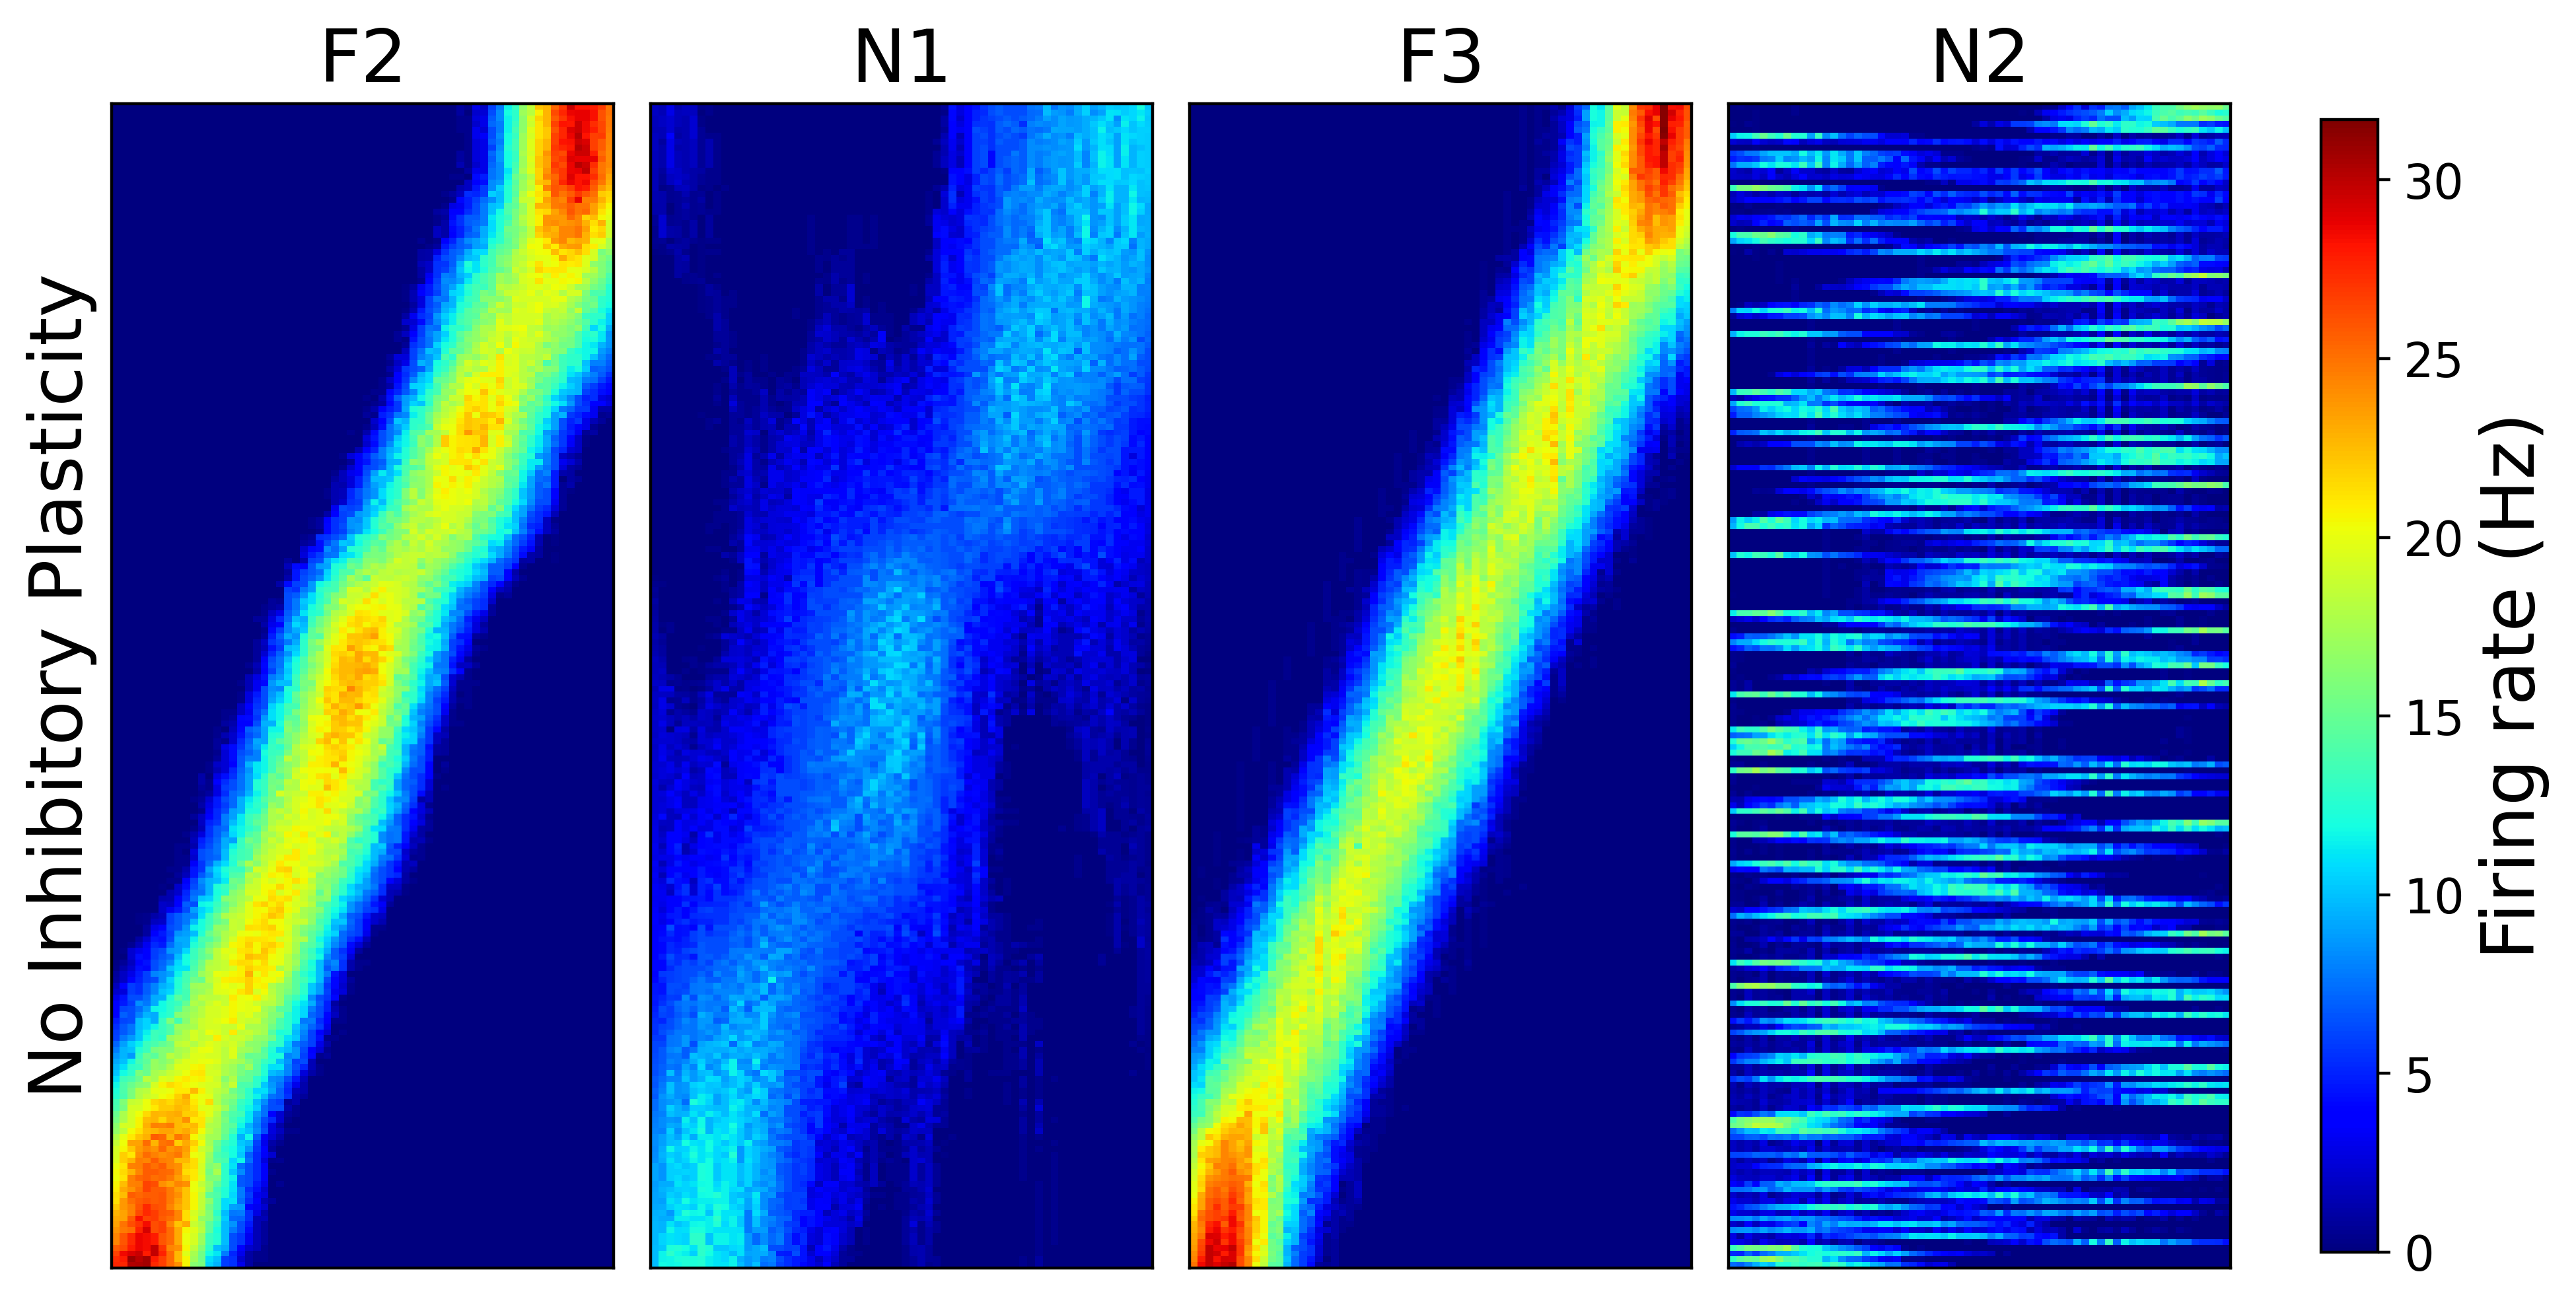

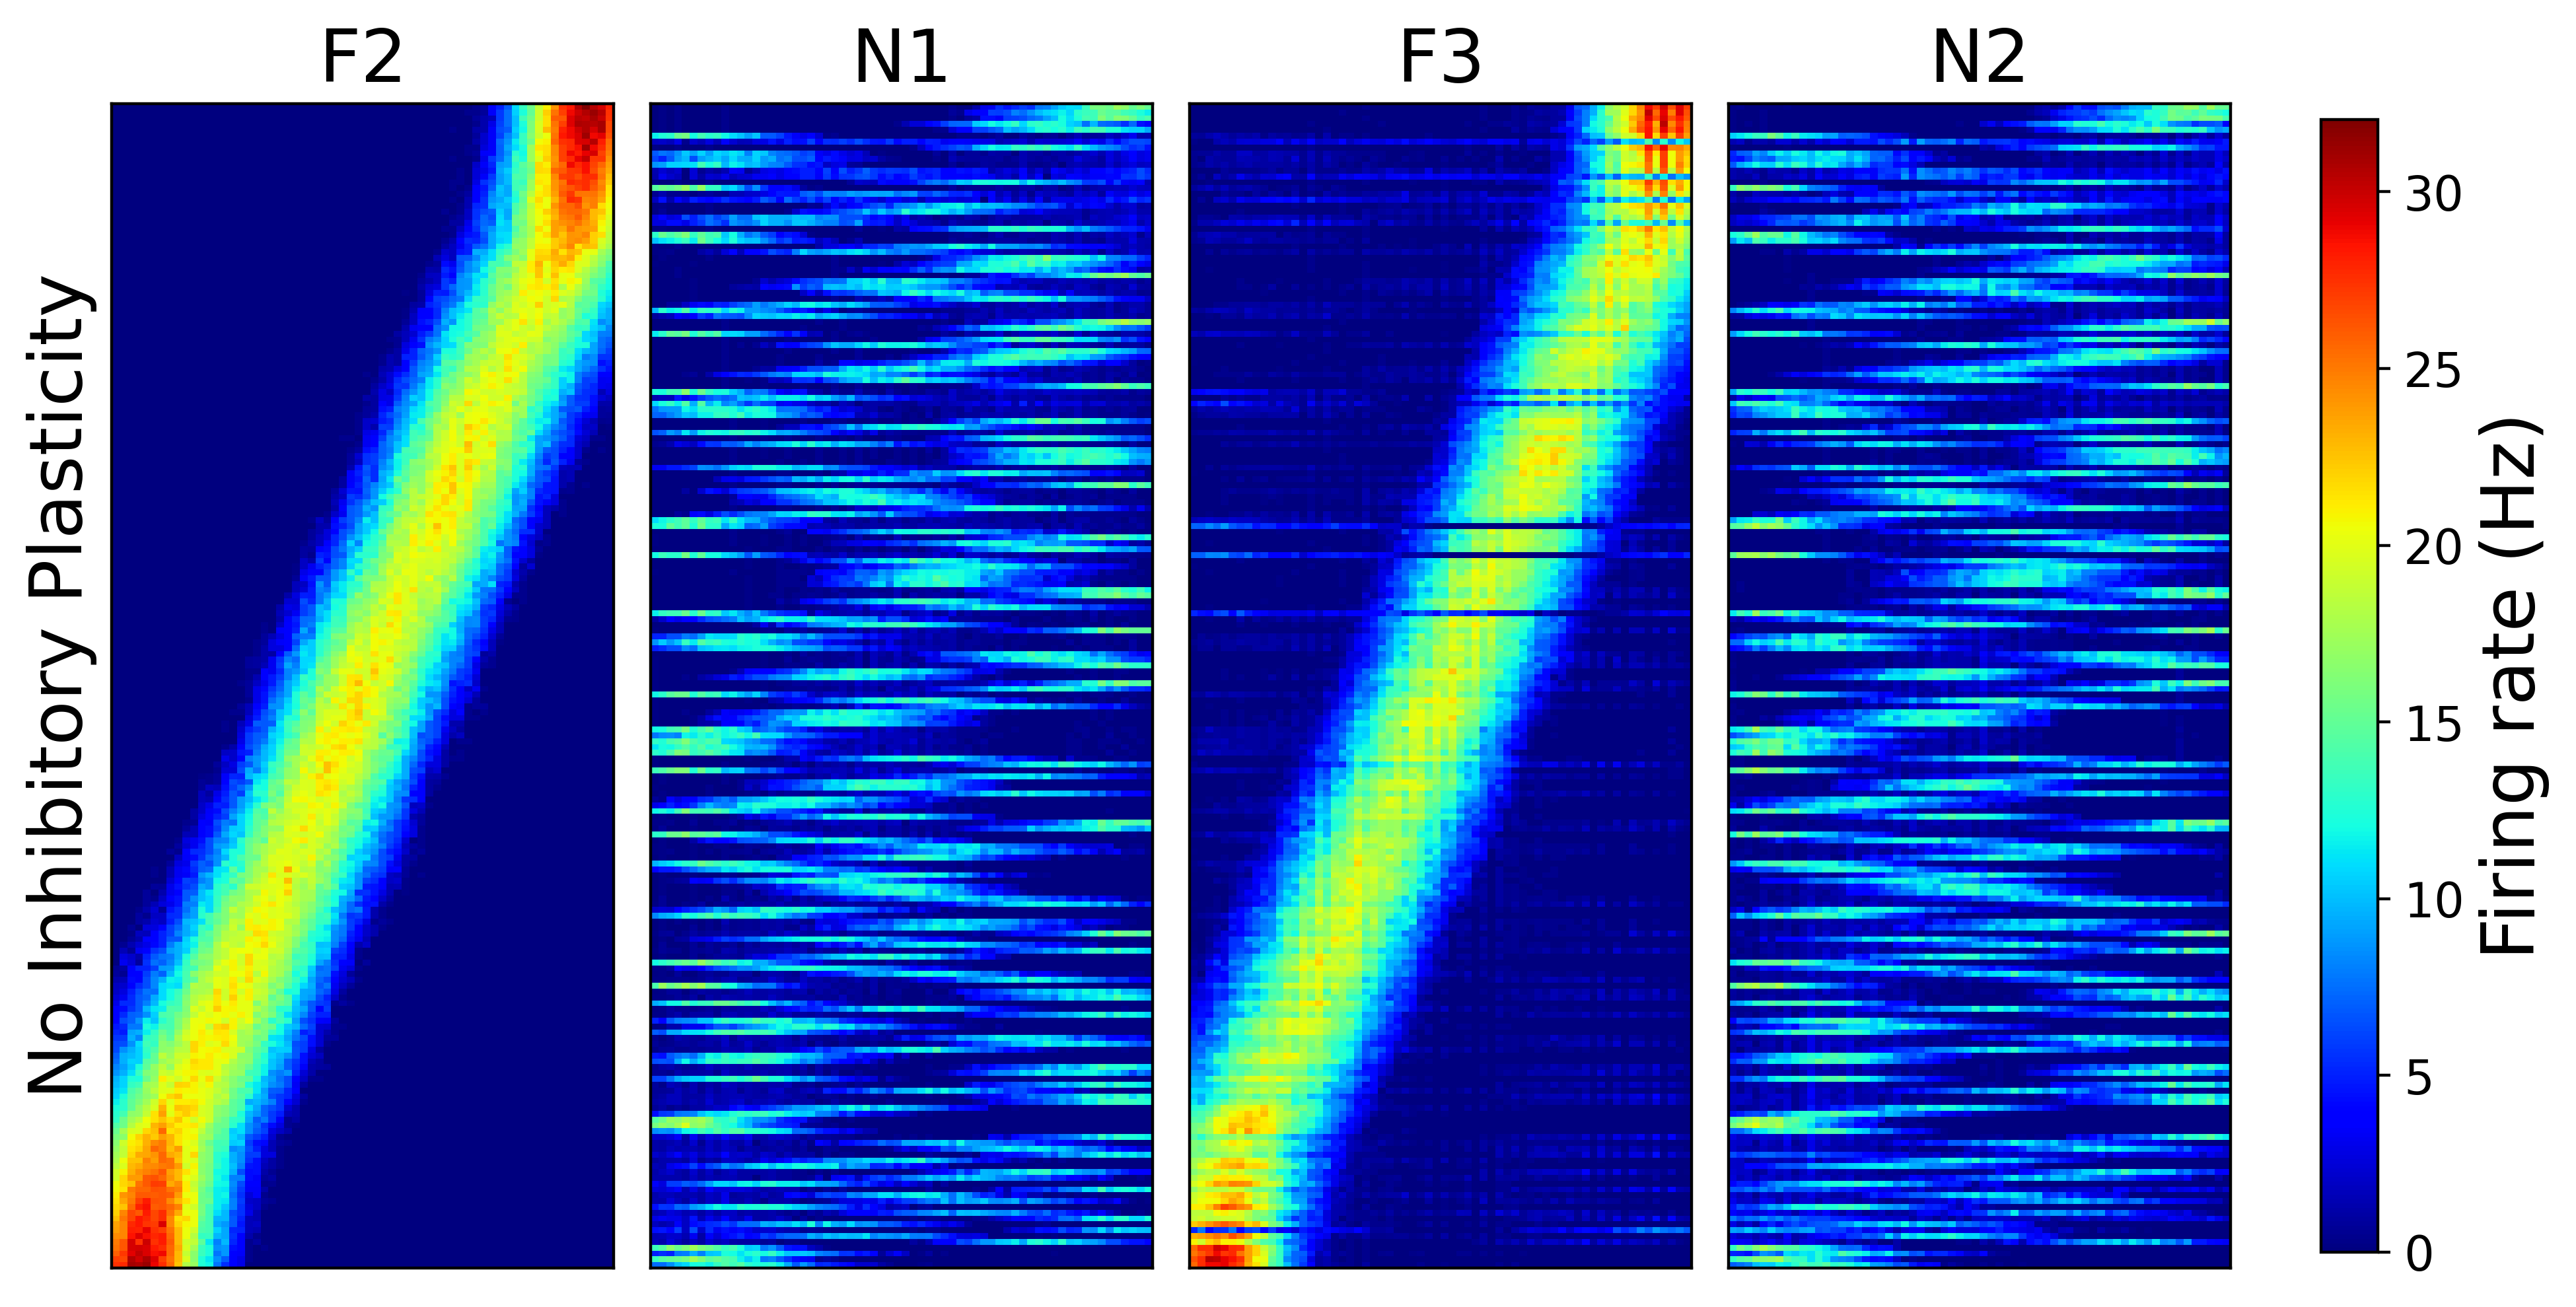

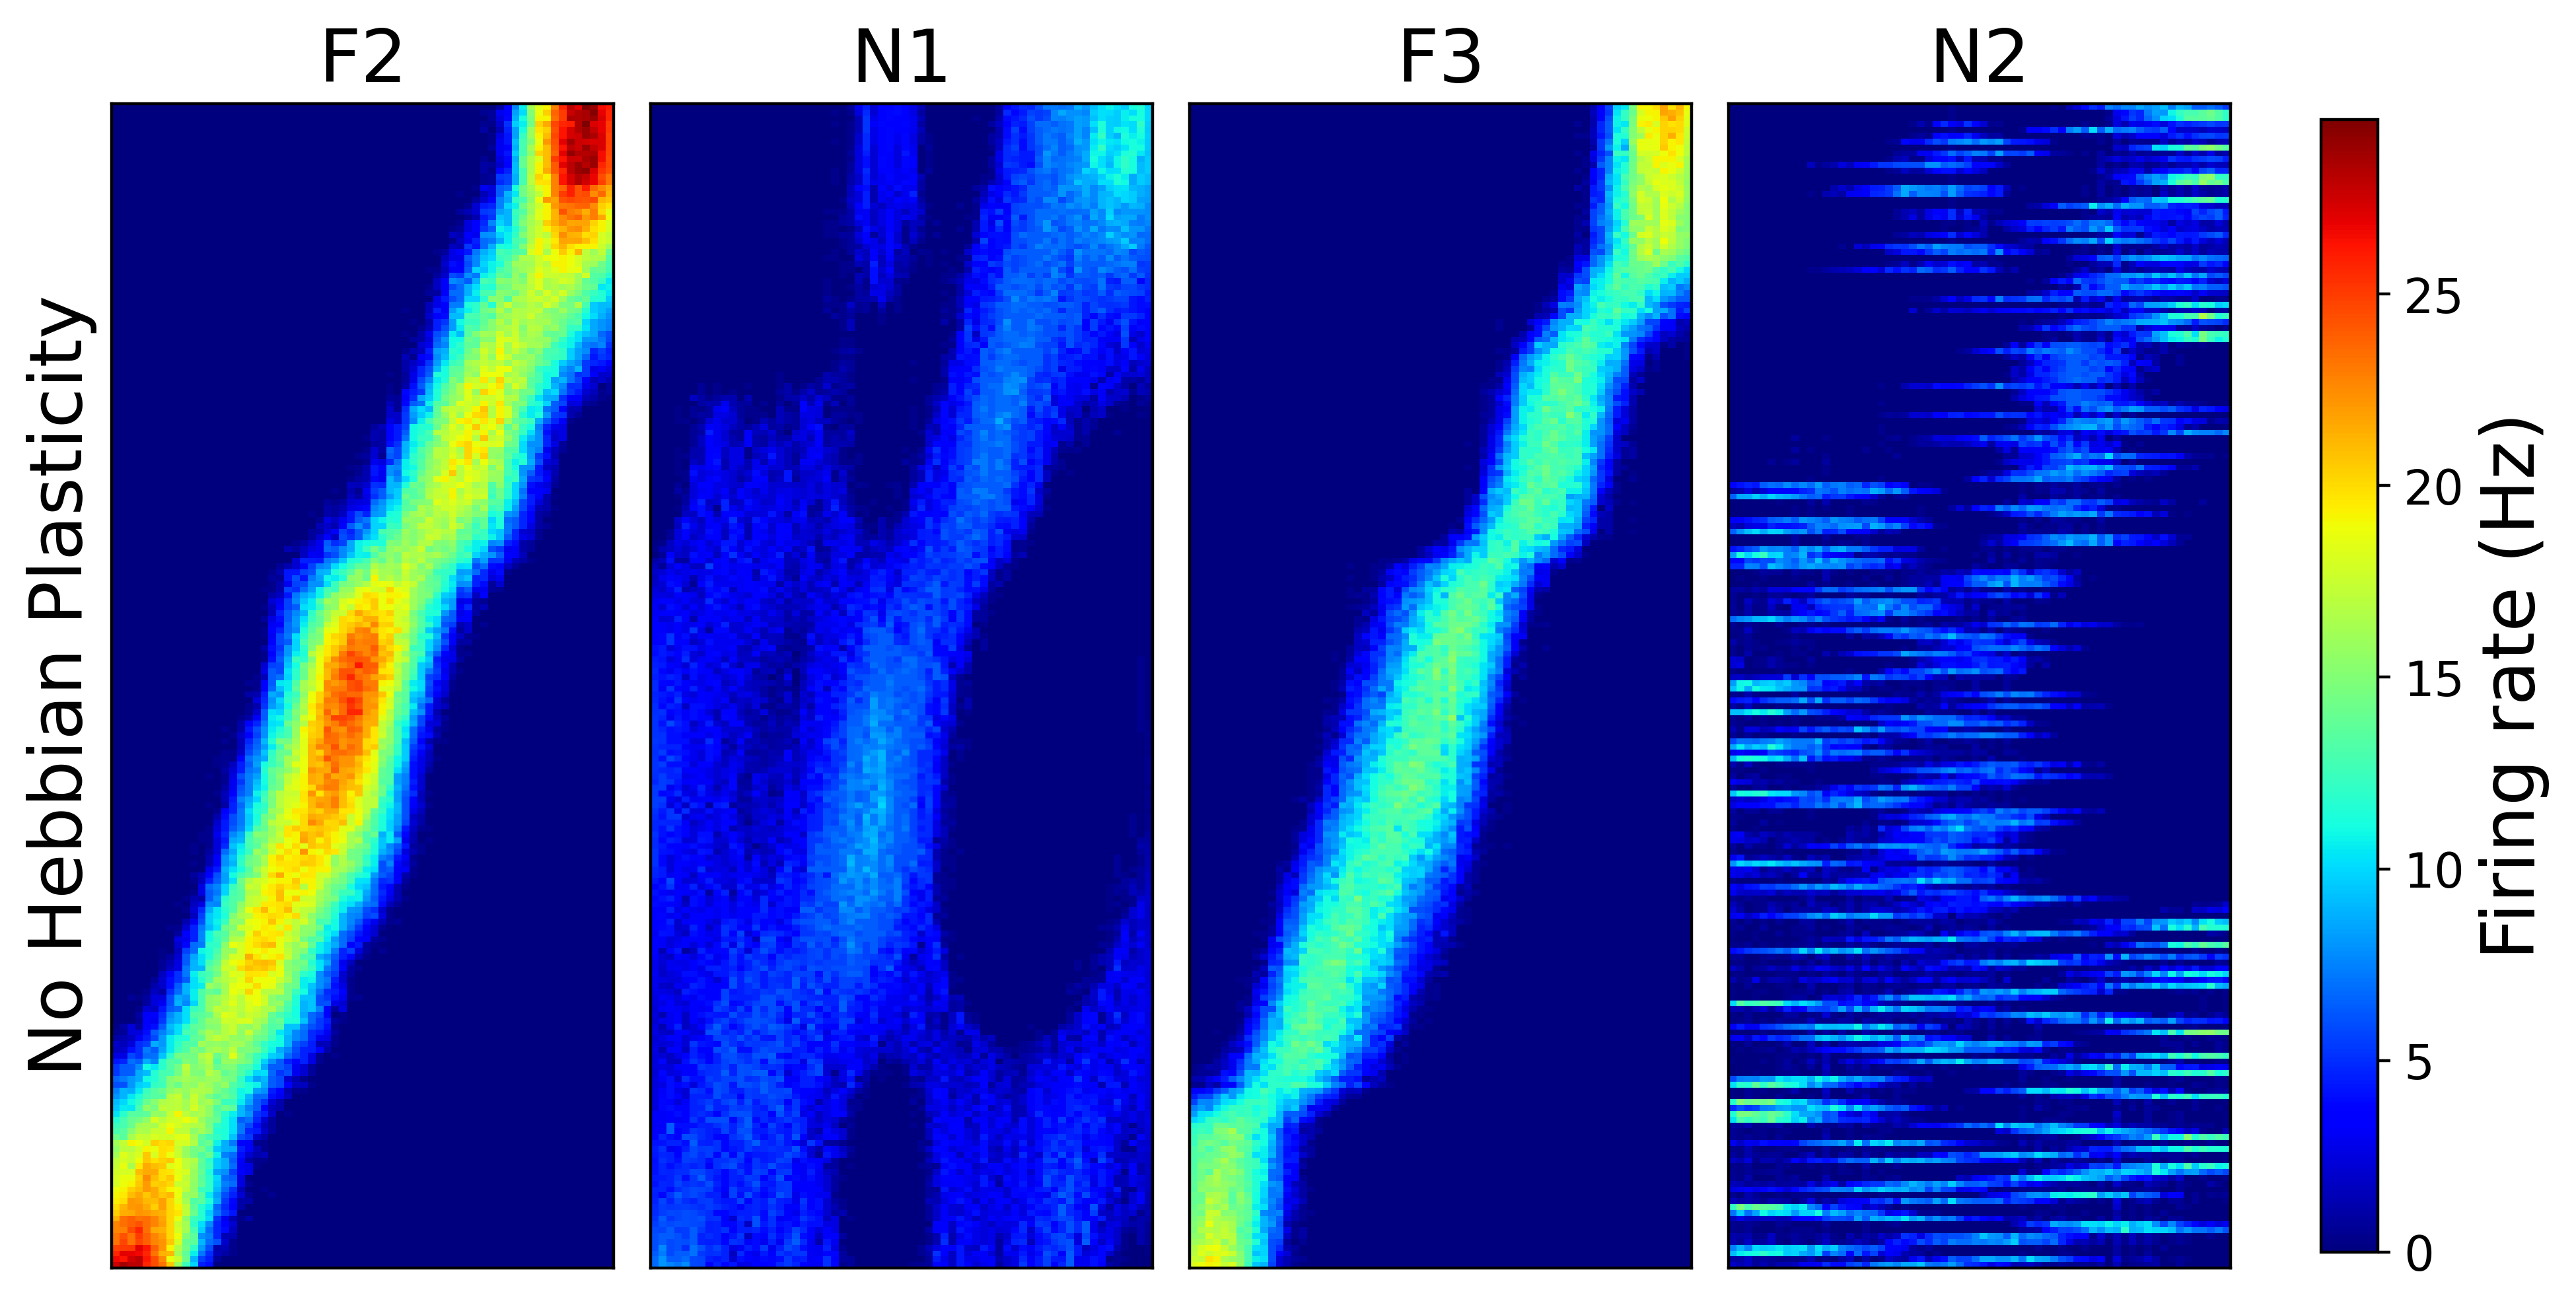

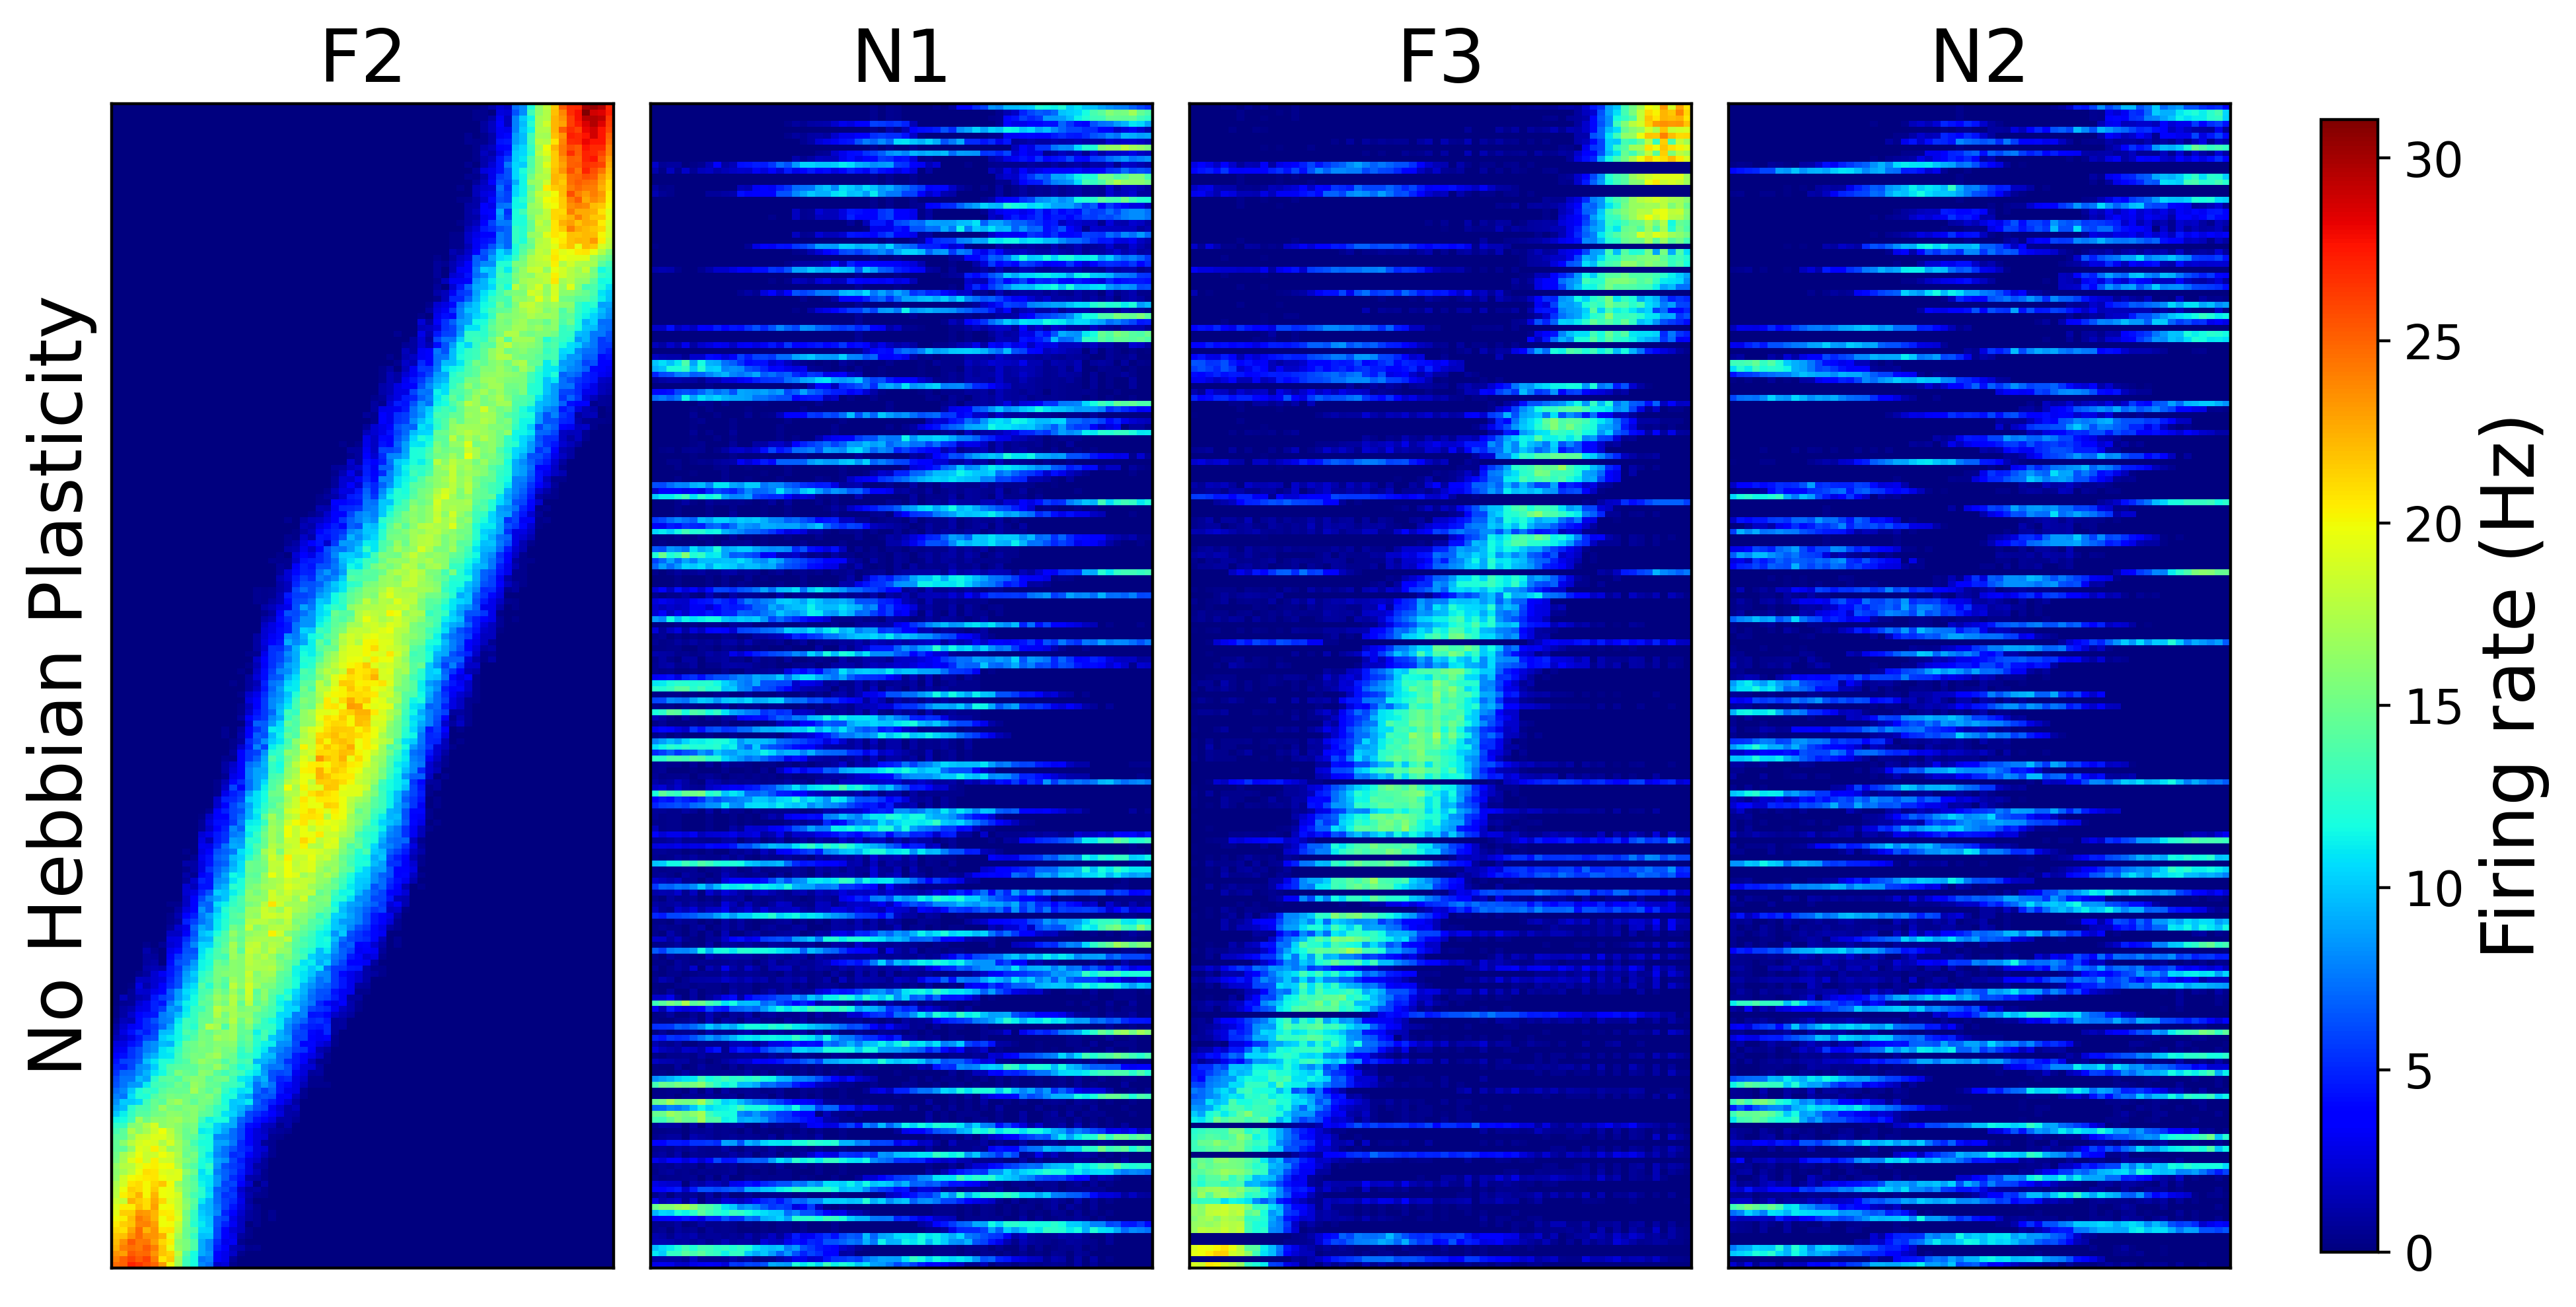

In [3]:
### plot activity maps for both conditions, all stages both groups

for scenario in ['no_inh', 'no_heb']:
    all_act_maps = amp_per_sc[scenario]['all_act_maps']
    for condition in ['exp', 'control']:
        plot_condition(all_act_maps[condition], "No Inhibitory Plasticity" if scenario == 'no_inh' else "No Hebbian Plasticity")

In [4]:
### adjust p-values and save results of tests.

all_ps = multipletests(p_vals, method='fdr_bh')[1]  # Adjust p-values for multiple comparisons

ps_exp = all_ps[:12].reshape(6, 2)
ps_control = all_ps[12:].reshape(6, 2)

out['exp'].loc[:, ['p1', 'p2']] = ps_exp
out['control'].loc[:, ['p1', 'p2']] = ps_control

for condition in ['exp', 'control']:
    out[condition]['name'] = list(out[condition].index.copy())
    out[condition]['name'] = out[condition]['name'].apply(lambda x: x.split('_')[0].replace('sp', 'spatial').replace('pvs', 'PV') + ' ' + x.split('_')[-2] + ' vs ' + x.split('_')[-1])

    out[condition]['p1'] = out[condition]['p1'].apply(format_val)
    out[condition]['p2'] = out[condition]['p2'].apply(format_val)
    
    out[condition].index = out[condition]['name']
    out[condition].rename(columns={'D_stat_no_inh': 'D1', 'p_no_inh': 'p1',
                                'D_stat_no_heb': 'D2', 'p_inh': 'p2'}, inplace=True)
    
    for i in range(1, 4):
        out[condition][fr'$\rho_{i}$'] = out[condition].apply(lambda row: f"{row[f'm{i}']} ± {row[f'sd{i}']}", axis=1)

    # out[condition].drop(columns=['name'], inplace=True)
    out[condition] = out[condition][[fr'$\rho_1$', fr'$\rho_2$', 'D1', 'p1', 'd()1', fr'$\rho_3$', 'D2', 'p2', 'd()2'] ]
    out[condition] = out[condition].iloc[[0, 3, 1, 4, 2, 5], :] 

    out[condition].to_csv(f'results/act_maps_and_pvs_{condition}_stats.csv')
    out[condition].to_latex(f'results/act_maps_and_pvs_{condition}_stats.tex', escape=False)
   

/tmp/ipykernel_933665/2040349564.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  out[condition].to_latex(f'results/act_maps_and_pvs_{condition}_stats.tex', escape=False)
/tmp/ipykernel_933665/2040349564.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  out[condition].to_latex(f'results/act_maps_and_pvs_{condition}_stats.tex', escape=False)
